**<span style="font-family:KerkisSans; font-size:2.5em;">Classification of Handwritten Digits</span>**

<span style="font-family:KerkisSans; font-size:1.5em; color: black">Anna Androvitsanea</span>

<span style="font-family:KerkisSans; font-size:1.5em; color: black">anna.androvitsanea@gmail.com</span>

<span style="font-family:KerkisSans; font-size:1.7em; color: black">In this project I present a program that classifies handwritten digits.</span>

<span style="font-family:KerkisSans; font-size:1.7em; color: black">The programm is written in Python and consists of the following steps.</span>

* Introduction
    * Import libraries
    * Import data
    * Perform an EDA

* Task 1
    * Construct the program
    * Tune the program for accuracy of classification
    * Present the % of correctly classified digits as a function of the number of basis vectors

* Task 2
    * Check level of difficulty pre digit to be classified
    * Check badly writen examples

* Task 3
    * Check the Singular Values of different classes
    * Check whether it makes sense to vary the number of basis vector per class
    * Perform experiment with variation of number of basis vectors

# **<span style="font-family:KerkisSans; font-size:1.8em; color: red">Introduction</span>**

## Import libraries

In [1]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

%matplotlib inline
from matplotlib import pyplot as plt

from scipy.linalg import svd

import numpy as np
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tabulate import tabulate
#! pip install progressbar2
import progressbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split  


## Import data

In [2]:
# import data

azip = pd.read_excel('data.xlsx', 'azip', 
                     header = None) # vector that holds the digits (the number)
dzip = pd.read_excel('data.xlsx', 'dzip', 
                     header = None) # 256 x 1707 array that holds the training images
testzip = pd.read_excel('data.xlsx', 'testzip', 
                        header = None) # test data
dtest = pd.read_excel('data.xlsx', 'dtest', 
                      header = None)  # test data

In [3]:
# rename and tranform to array

labels_train = dzip.to_numpy()
train = azip.to_numpy()
labels_test = dtest.to_numpy()
test = testzip.to_numpy()

In [4]:
# check shapes of data
labels_train.shape, train.shape, labels_test.shape, test.shape

((1, 1707), (256, 1707), (1, 2007), (256, 2007))

In [5]:
# merge train and test set to prepare 
# for train/test splitting
X = np.concatenate((train, test), axis = 1)
y = np.concatenate((labels_train.reshape(1707), 
                    labels_test.reshape(2007)))

In [6]:
### ===== train/test splitting ===== ###
### ------------------------------------ ###
idx1 = int(round(3714*0.8, 0))
idx2 = idx1 + 1
X_train, X_test = X[:,:idx1], X[:,idx2:]
y_train, y_test = y[:idx1], y[idx2:]

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((256, 2971), (256, 742), (2971,), (742,))

## **<span style="font-family:KerkisSans; font-size:1.8em; color: red">Exploratory data analysis</span>**

In [8]:
# check dimensions

print("Size of training data are:", 
      y_train.shape, X_train.shape)
print("Size of testing data are:", 
      y_test.shape, X_test.shape)

Size of training data are: (2971,) (256, 2971)
Size of testing data are: (742,) (256, 742)


In [9]:
# check training data
# check frequency per digit
unique, counts = np.unique(y_train, return_counts=True)
counts = np.asarray((unique, counts))

In [10]:
for digit in counts[0]:
    print(counts[0][digit], counts[1][digit])

0 567
1 402
2 328
3 236
4 235
5 166
6 269
7 260
8 260
9 248


In [11]:
# check test data
# check frequency per digit
unique_test, counts_test = np.unique(y_test, return_counts=True)
counts_test = np.asarray((unique_test, counts_test))

In [12]:
for digit in counts_test[0]:
    print(counts_test[0][digit], counts_test[1][digit])

0 111
1 114
2 72
3 61
4 87
5 82
6 51
7 53
8 50
9 61


This digit represents number 5.


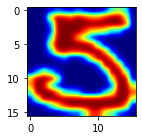

In [13]:
# plot random digit from train

image = 1
fig = plt.figure(figsize=(4,2))
plt.imshow(X_train[:, image].reshape((16,16)), 
           interpolation='gaussian',
           cmap='jet')
print("This digit represents number %d." %y_train[image])
plt.show()

This digit represents number 8.


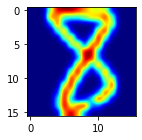

In [14]:
# plot random digit from test

fig = plt.figure(figsize=(4,2))
plt.imshow(X_test[:, image].reshape((16,16)), 
           interpolation='gaussian',
           cmap='jet')
print("This digit represents number %d." %y_test[image])
plt.show()

# **<span style="font-family:KerkisSans; font-size:1.8em; color: red">Task 1</span>**

## Step 1: Calculate SVD

<span style="font-family:KerkisSans; font-size:1.7em; color: black">For each digit I will calculate the SVD, based on the training data.</span>

Specifically, the singular value decomposition of the m × n ${\displaystyle m\times n} m\times n$ complex matrix **M** will be calculated as the factorization of the form $${\displaystyle \mathbf {U\Sigma V^{*}}}$$
* **U** is an m × m ${\displaystyle m\times m} m\times m$ complex unitary matrix, 
* ${\displaystyle \mathbf {\Sigma } }$ is an ${\displaystyle m\times n}$ rectangular diagonal matrix with non-negative real numbers on the diagonal, and 
* **V** is an ${\displaystyle n\times n}$ complex unitary matrix. 

In [15]:
# Calculate the SVD for each digit

SVD = {d:{} for d in range(10)} # store the SVD for each digit, d
for d in range(10):
    # index train dataset per digit
    SVD[d] = np.linalg.svd(X_train[:, np.where(y_train == d)[0]], 
                        full_matrices=True)

## Step 2: Tuning

For the given number of basis vectors, n = 5 - 20, I extract the first n columns of the **U** matrix of the calculated SVD. 

I will then calculate the residuals based on the relation $||(I - U_kU_k^T)z ||$ for each digit. 

The minimum residual per digit for each test image will yield the digit that the image represents. 

In [16]:
clas_rep = {}
cm = {}
accuracy = {}

# n is the number of basis vectors
for n in progressbar.progressbar(range(5, 21)): 
    print("Calculating for %d basis vectors." %n)
    
    # calculate the U_k @ U_k.T once and store it
    UUT  = {}
    
    for d in range(10): # for each digit
        UUT[d] = SVD[d][0][:, :n] @ SVD[d][0][:, :n].T
        
    # store results for residuals and predictions
    res = np.zeros(10)
    classify = np.zeros(X_test.shape[1])
    bad = np.zeros(X_test.shape[1])     
    

    for image in range(X_test.shape[1]): # iterate over the vectors of test images (2007)
        for d in range(10): # iterate over the number of digits (0-9)
            res[d] = np.linalg.norm((np.identity(X_test.shape[0]) - UUT[d])@X_test[:, image])

        # for each image extract the index
        # for the minimum residual
        # and classify
        classify[image] = np.argmin(res)
        bad[image] = np.argmax(res)

    # for each basis vector n
    # store the classification report, ie. the F1 and recall
    clas_rep[n] = classification_report(y_test, classify, output_dict = True)

    # store confusion matrix
    cm[n] = confusion_matrix(y_test, classify)

    # store accuracy    
    accuracy[n] = cm[n].trace() / X_test.shape[1] 
       

N/A% (0 of 16) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Calculating for 5 basis vectors.


  6% (1 of 16) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:25

Calculating for 6 basis vectors.


 12% (2 of 16) |###                      | Elapsed Time: 0:00:03 ETA:   0:00:23

Calculating for 7 basis vectors.


 18% (3 of 16) |####                     | Elapsed Time: 0:00:05 ETA:   0:00:26

Calculating for 8 basis vectors.


 25% (4 of 16) |######                   | Elapsed Time: 0:00:06 ETA:   0:00:21

Calculating for 9 basis vectors.


 31% (5 of 16) |#######                  | Elapsed Time: 0:00:09 ETA:   0:00:23

Calculating for 10 basis vectors.


 37% (6 of 16) |#########                | Elapsed Time: 0:00:12 ETA:   0:00:36

Calculating for 11 basis vectors.


 43% (7 of 16) |##########               | Elapsed Time: 0:00:17 ETA:   0:00:37

Calculating for 12 basis vectors.


 50% (8 of 16) |############             | Elapsed Time: 0:00:19 ETA:   0:00:18

Calculating for 13 basis vectors.


 56% (9 of 16) |##############           | Elapsed Time: 0:00:21 ETA:   0:00:14

Calculating for 14 basis vectors.


 62% (10 of 16) |###############         | Elapsed Time: 0:00:22 ETA:   0:00:10

Calculating for 15 basis vectors.


 68% (11 of 16) |################        | Elapsed Time: 0:00:24 ETA:   0:00:08

Calculating for 16 basis vectors.


 75% (12 of 16) |##################      | Elapsed Time: 0:00:26 ETA:   0:00:06

Calculating for 17 basis vectors.


 81% (13 of 16) |###################     | Elapsed Time: 0:00:28 ETA:   0:00:05

Calculating for 18 basis vectors.


 87% (14 of 16) |#####################   | Elapsed Time: 0:00:29 ETA:   0:00:03

Calculating for 19 basis vectors.


 93% (15 of 16) |######################  | Elapsed Time: 0:00:31 ETA:   0:00:01

Calculating for 20 basis vectors.


100% (16 of 16) |########################| Elapsed Time: 0:00:32 Time:  0:00:32


## Step 3: Scores

In [17]:
# Print the names of the columns.
print ("{:<10} {:<10}".format('Basis vec.', 'Accuracy (%)'))
  
# print each data item.
for key in accuracy.keys():
    print ("{:<10} {:.2f}".format(key, round(accuracy[key] * 100, 2)))

Basis vec. Accuracy (%)
5          92.05
6          92.99
7          92.32
8          92.72
9          93.40
10         93.80
11         94.47
12         94.47
13         94.61
14         94.61
15         95.01
16         94.88
17         94.34
18         94.61
19         94.88
20         94.74


No handles with labels found to put in legend.


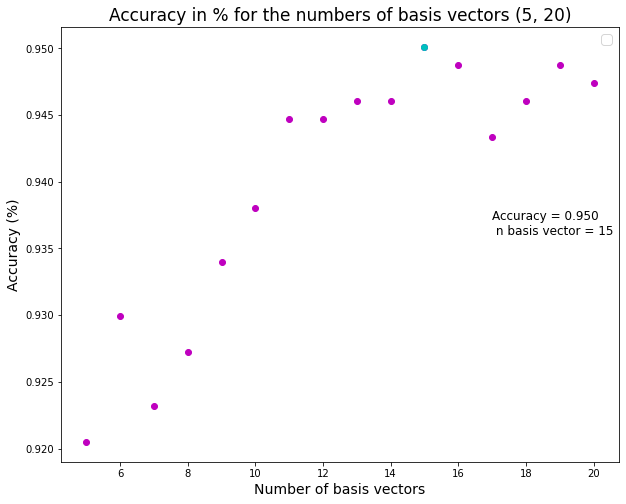

In [18]:
# plot number of basis vectors and accuracy scores
# plot the highest accuracy

plt.figure(figsize=(10,8)) # set the size of figure

# plot accuracy for each number of basis vectors
plt.scatter(accuracy.keys() , accuracy.values(), c= 'm')

# Plot the maximum accuracy of the curve
# list of keys and values
keys = list(accuracy.keys())
values = list(accuracy.values())
plt.scatter(keys[values.index(max(values))], max(values), 
            c = 'c')
plt.text(17, 0.936,
         'Accuracy = %.3f  \n n basis vector = %d' % ( max(values),
          keys[values.index(max(values))]), fontsize=12)

plt.title('Accuracy in % for the numbers of basis vectors (5, 20)', 
          fontsize=17) # add a title
plt.xlabel('Number of basis vectors', fontsize=14) # add x label
plt.ylabel('Accuracy (%)', fontsize=14) # add y label
plt.legend(fontsize = 14)

plt.show()

# **<span style="font-family:KerkisSans; font-size:1.8em; color: red">Task 2</span>**

In [19]:
# view the confusion matrix
for n in range(5, 21):
    print("Confusion matrix for %d basis vectors" %n)
    print("---------------------------------------------------")    
    print(pd.DataFrame(cm[n], 
                       index = [i for i in range(0, 10)], 
                       columns = [i for i in range(0, 10)]))
    print("---------------------------------------------------")

Confusion matrix for 5 basis vectors
---------------------------------------------------
     0    1   2   3   4   5   6   7   8   9
0  111    0   0   0   0   0   0   0   0   0
1    0  111   0   0   3   0   0   0   0   0
2    1    1  65   0   2   1   2   0   0   0
3    1    0   1  55   0   2   0   0   1   1
4    2    0   2   0  72   0   2   3   1   5
5    3    0   0   6   0  72   0   0   1   0
6    1    0   0   0   1   0  49   0   0   0
7    0    0   0   1   0   0   0  49   0   3
8    0    0   1   4   1   1   0   1  41   1
9    0    0   0   0   1   0   0   1   1  58
---------------------------------------------------
Confusion matrix for 6 basis vectors
---------------------------------------------------
     0    1   2   3   4   5   6   7   8   9
0  111    0   0   0   0   0   0   0   0   0
1    0  111   0   0   3   0   0   0   0   0
2    0    1  68   0   2   0   1   0   0   0
3    2    0   1  54   0   2   0   0   1   1
4    0    0   1   0  76   0   1   5   1   3
5    1    1   0   6   

In [20]:
for n in range(5, 21):
    print("       Classification report for %d basis vectors" %n)
    print("-------------------------------------------------------")      
    print(pd.DataFrame(clas_rep[n]).transpose())
    print("-------------------------------------------------------")

       Classification report for 5 basis vectors
-------------------------------------------------------
              precision    recall  f1-score     support
0              0.932773  1.000000  0.965217  111.000000
1              0.991071  0.973684  0.982301  114.000000
2              0.942029  0.902778  0.921986   72.000000
3              0.833333  0.901639  0.866142   61.000000
4              0.900000  0.827586  0.862275   87.000000
5              0.947368  0.878049  0.911392   82.000000
6              0.924528  0.960784  0.942308   51.000000
7              0.907407  0.924528  0.915888   53.000000
8              0.911111  0.820000  0.863158   50.000000
9              0.852941  0.950820  0.899225   61.000000
accuracy       0.920485  0.920485  0.920485    0.920485
macro avg      0.914256  0.913987  0.912989  742.000000
weighted avg   0.921822  0.920485  0.920083  742.000000
-------------------------------------------------------
       Classification report for 6 basis vectors
------

## Best results

<span style="font-family:KerkisSans; font-size:1.7em; color: black">For the number of basis vectors that provide the best accuracy, aka n = 18 I will find the relevant scores per digit.</span>

In [21]:
# select the confusion matrix for the optimum
# number of basis vectors
opt_cm = pd.DataFrame(cm[keys[values.index(max(values))]], 
                       index = [i for i in range(0, 10)], 
                       columns = [i for i in range(0, 10)])

In [22]:
# find best scores
# per digit
# correctly identified digits/all digits 
opt_res = []
for pos in range(opt_cm.shape[0]):
    accu = opt_cm.loc[pos, pos] / opt_cm.loc[pos,:].sum()
    opt_res.append(round(100 * accu, 2))

In [23]:
pd.DataFrame(opt_res, 
          index = [i for i in range(0,10)],
          columns = ['accuracy'])

,accuracy
0,100.00
1,97.37
2,95.83
3,90.16
4,94.25
5,91.46
6,96.08
7,98.11
8,88.00
9,93.44


## Worst digits

In [24]:
# sort in ascending order

print("Digit |","Accuracy")
accuracies = pd.DataFrame(opt_res, 
          index = [i for i in range(0,10)],
          columns = ['accuracy'])
# sort asceding
# check values with lowest score
accuracies.sort_values(by='accuracy')

Digit | Accuracy


,accuracy
8,88.00
3,90.16
5,91.46
9,93.44
4,94.25
2,95.83
6,96.08
1,97.37
7,98.11
0,100.00


<span style="font-family:KerkisSans; font-size:1.7em; color: black">I notice that digits **8**, **3**, **5** and **9** have the worse accuracy, meaning that they have been the most difficult to get identified.</span>

<span style="font-family:KerkisSans; font-size:1.7em; color: black">Let's take a closer look on their plots</span>

### Digit 8

In [27]:
# store dimensions of shape

dim0_8 = X_test[:, np.where(y_test == 8)].shape[0]
dim2_8 = X_test[:, np.where(y_test == 8)].shape[2]
dim0_8, dim2_8

(256, 50)

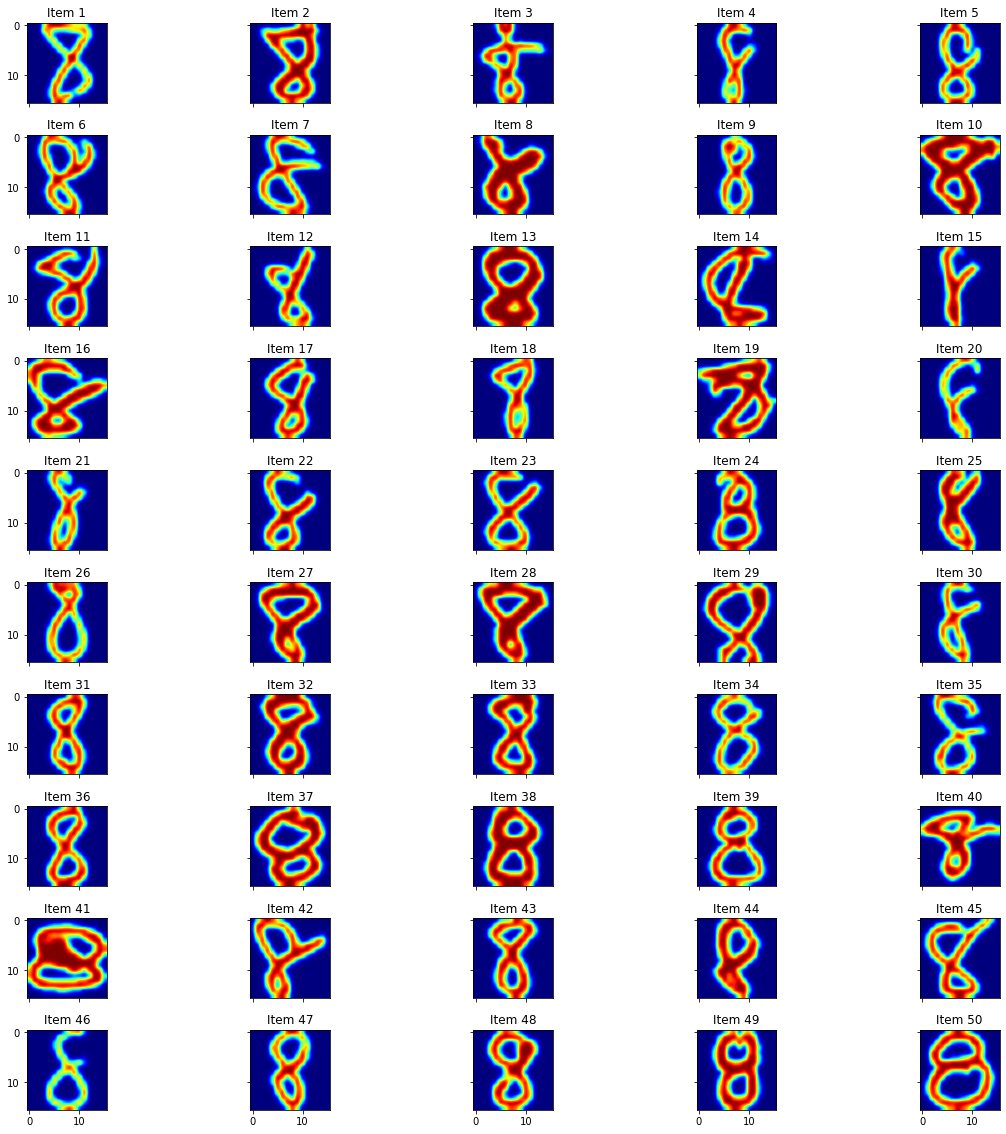

In [28]:
# Plot all 8s

fig = plt.figure(figsize = (20, 20))
gs = fig.add_gridspec(nrows = 10, ncols = 5, 
                      hspace=0.4, wspace=0)

axes = gs.subplots(sharex='col', sharey='row')

for item, ax in enumerate(axes.flatten()): 
    ax.imshow(X_test[:, np.where(y_test == 8)].reshape(dim0_8, 
                                                       dim2_8)[:, item].reshape((16,16)), 
               interpolation='gaussian',
               cmap='jet')
    ax.set_title('Item %d'% (item + 1), fontsize = 12)
    
plt.show()

<span style="font-family:KerkisSans; font-size:1.7em; color: black">Looking at the plots I notice that the quality of the image is often pure and therefore difficult to classify.</span>

### Digit 3

In [29]:
# store dimensions of shape

dim0_3 = X_test[:, np.where(y_test == 3)].shape[0]
dim2_3 = X_test[:, np.where(y_test == 3)].shape[2]
dim0_3, dim2_3

(256, 61)

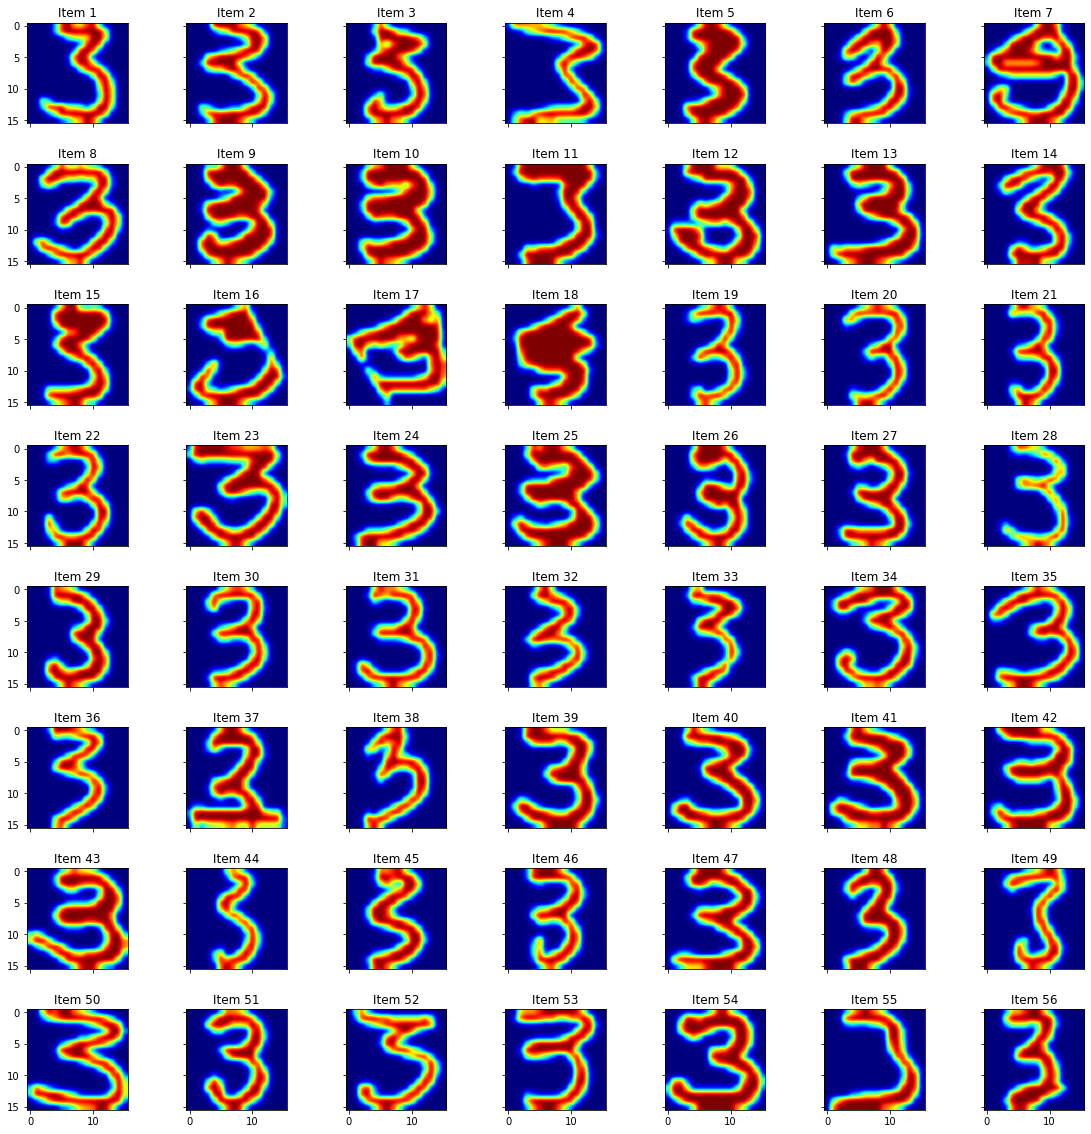

In [31]:
# Plot all 3s

fig = plt.figure(figsize = (20, 20))
gs = fig.add_gridspec(nrows = 8, ncols = 7, 
                      hspace=0.4, wspace=0)

axes = gs.subplots(sharex='col', sharey='row')

for item, ax in enumerate(axes.flatten()): 
    ax.imshow(X_test[:, np.where(y_test == 3)].reshape(dim0_3, 
                                                       dim2_3)[:, item].reshape((16,16)), 
               interpolation='gaussian',
               cmap='jet')
    ax.set_title('Item %d'% (item + 1), fontsize = 12)
    
plt.show()

<span style="font-family:KerkisSans; font-size:1.7em; color: black">Looking at the plots I notice that the quality of the image is often pure and therefore difficult to classify.</span>

### Digit 5

In [32]:
# store dimensions of shape

dim0_5 = X_test[:, np.where(y_test == 5)].shape[0]
dim2_5 = X_test[:, np.where(y_test == 5)].shape[2]
dim0_5, dim2_5

(256, 82)

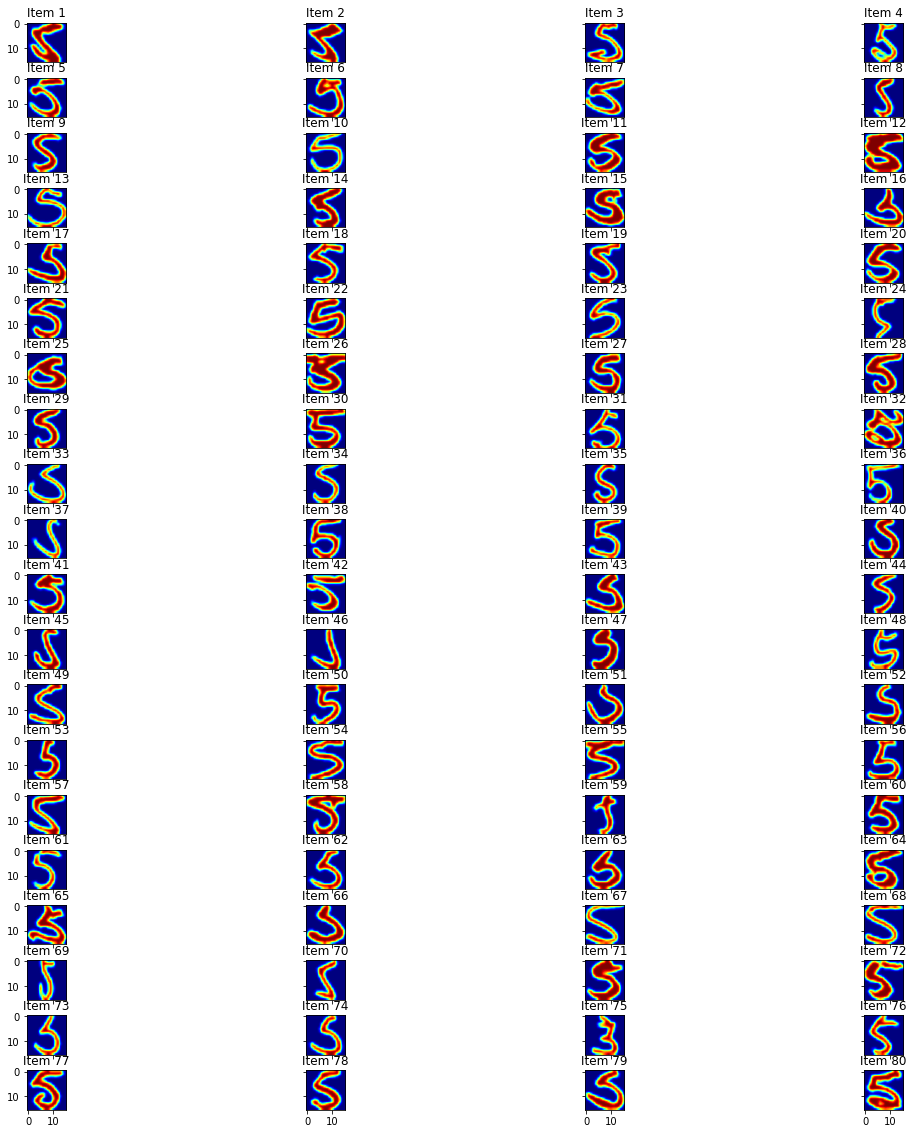

In [33]:
# Plot all 5s

fig = plt.figure(figsize = (20, 20))
gs = fig.add_gridspec(nrows = 20, ncols = 4, 
                      hspace=0.4, wspace=0)

axes = gs.subplots(sharex='col', sharey='row')

for item, ax in enumerate(axes.flatten()): 
    ax.imshow(X_test[:, np.where(y_test == 5)].reshape(dim0_5, 
                                                       dim2_5)[:, item].reshape((16,16)), 
               interpolation='gaussian',
               cmap='jet')
    ax.set_title('Item %d'% (item + 1), fontsize = 12)
    
plt.show()

<span style="font-family:KerkisSans; font-size:1.7em; color: black">Looking at the plots I notice that the quality of the image is often pure and therefore difficult to classify.</span>

### Digit 9

In [34]:
# store dimensions of shape

dim0_9 = X_test[:, np.where(y_test == 9)].shape[0]
dim2_9 = X_test[:, np.where(y_test == 9)].shape[2]
dim0_9, dim2_9

(256, 61)

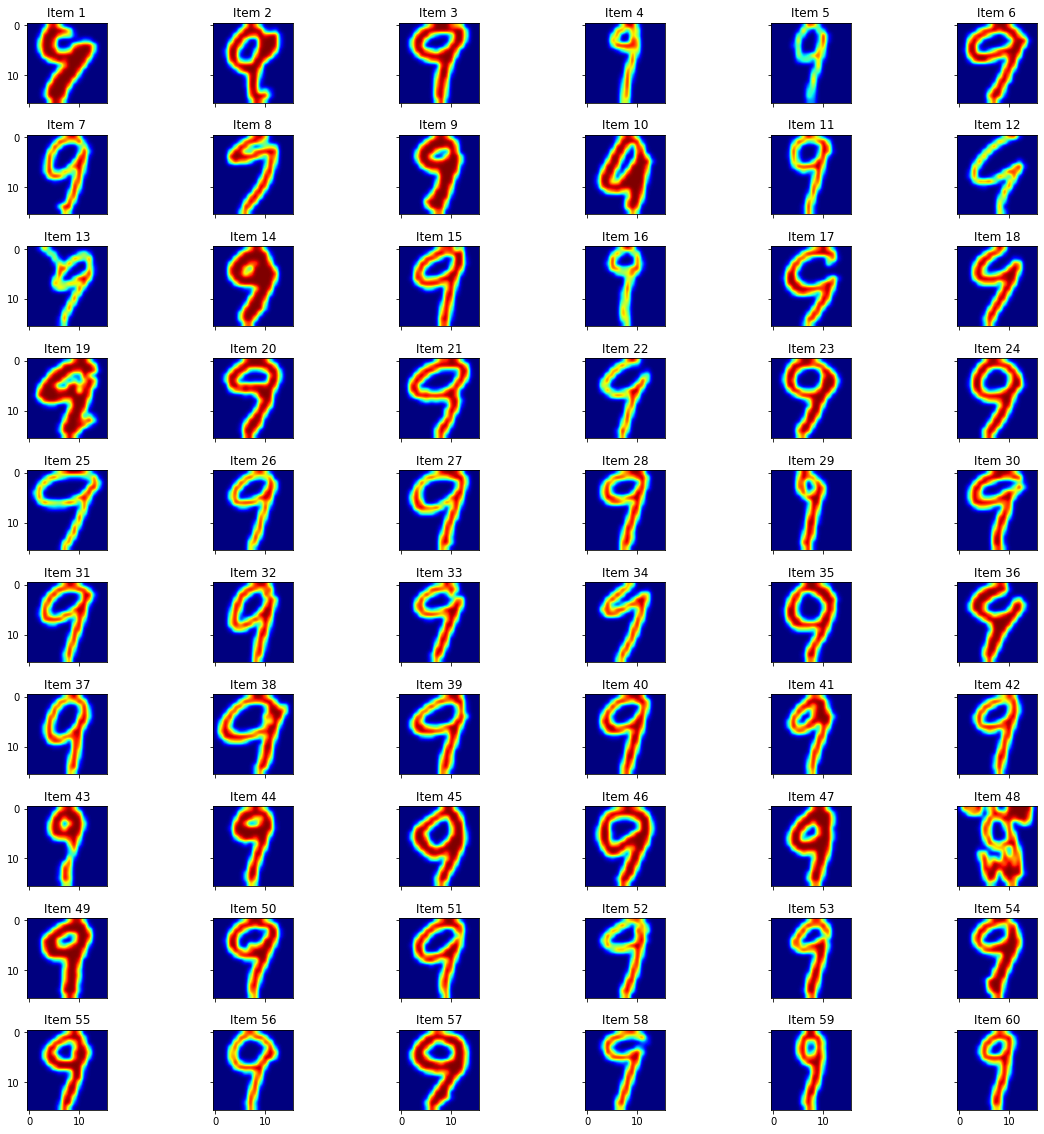

In [37]:
# Plot all 9s

fig = plt.figure(figsize = (20, 20))
gs = fig.add_gridspec(nrows = 10, ncols = 6, 
                      hspace=0.4, wspace=0)

axes = gs.subplots(sharex='col', sharey='row')

for item, ax in enumerate(axes.flatten()): 
    ax.imshow(X_test[:, np.where(y_test == 9)].reshape(dim0_9, 
                                                       dim2_9)[:, item].reshape((16,16)), 
               interpolation='gaussian',
               cmap='jet')
    ax.set_title('Item %d'% (item + 1), fontsize = 12)
    
plt.show()

<span style="font-family:KerkisSans; font-size:1.7em; color: black">Looking at the plots I notice that the quality of the image is often pure and therefore difficult to classify.</span>

<span style="font-family:KerkisSans; font-size:1.7em; color: black">But let's also check digits **0** and **1** which have the highest score in regard to their accurate classification.</span>

## Best digits

### Digit 0

In [38]:
# store dimensions of shape

dim0_0 = X_test[:, np.where(y_test == 0)].shape[0]
dim2_0 = X_test[:, np.where(y_test == 0)].shape[2]
dim0_0, dim2_0

(256, 111)

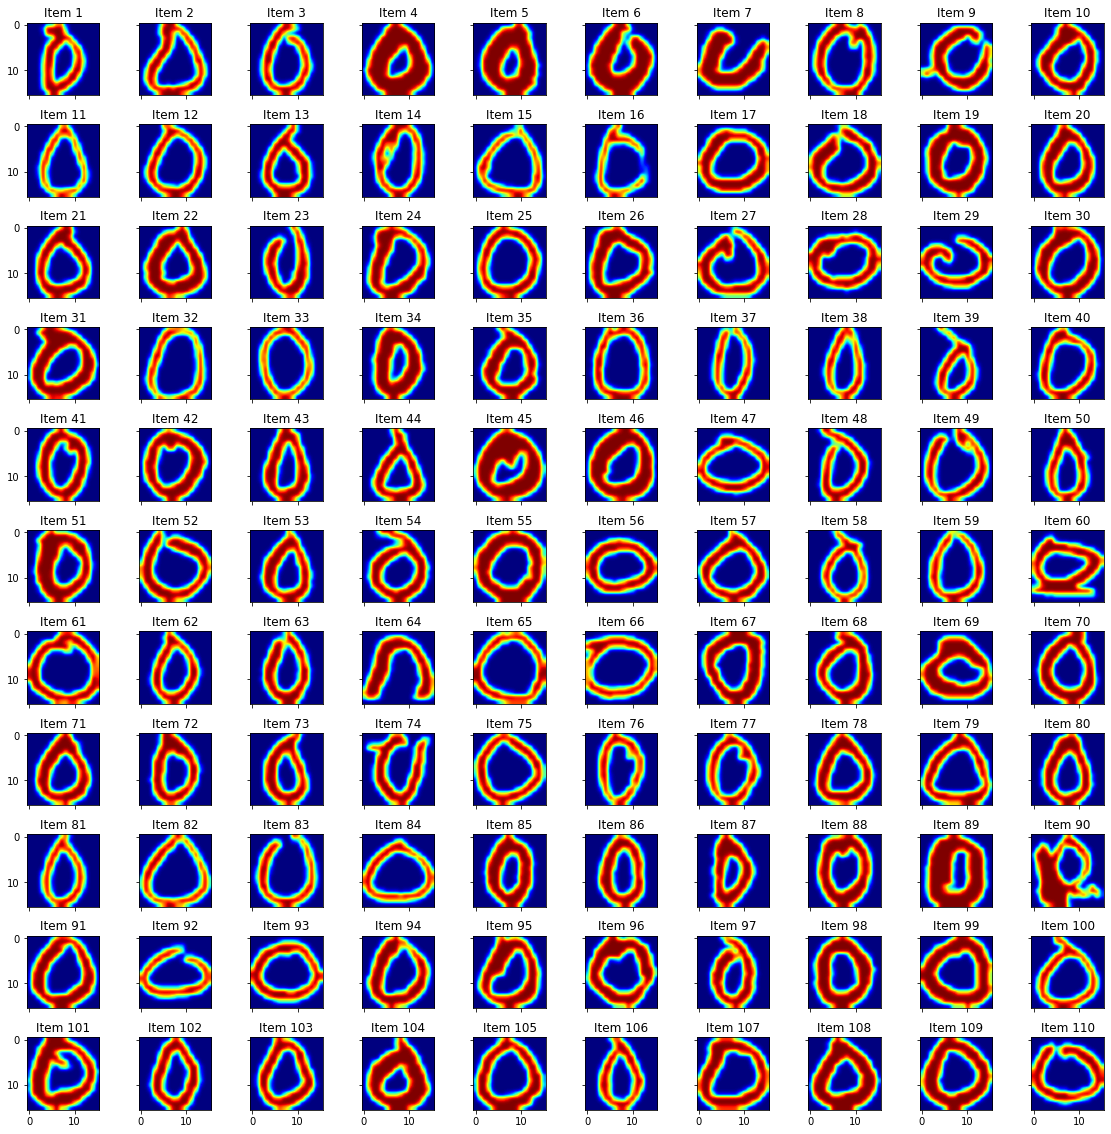

In [39]:
# Plot all 0s

fig = plt.figure(figsize = (20, 20))
gs = fig.add_gridspec(nrows = 11, ncols = 10, 
                      hspace=0.4, wspace=0)

axes = gs.subplots(sharex='col', sharey='row')

for item, ax in enumerate(axes.flatten()): 
    ax.imshow(X_test[:, np.where(y_test == 0)].reshape(dim0_0, 
                                                       dim2_0)[:, item].reshape((16,16)), 
               interpolation='gaussian',
               cmap='jet')
    ax.set_title('Item %d'% (item + 1), fontsize = 12)
    
plt.show()

<span style="font-family:KerkisSans; font-size:1.7em; color: black">Looking at the plots I notice that the quality of the image is excelent and therefore easy for digit 0 to be classified.</span>

<span style="font-family:KerkisSans; font-size:1.7em; color: black">This is rather due to the fact that 0 is a simple figure, being only one circle. Someone should try hard in order to write an illegible 0.</span>

### Digit 1

In [40]:
# store dimensions of shape

dim0_1 = X_test[:, np.where(y_test == 1)].shape[0]
dim2_1 = X_test[:, np.where(y_test == 1)].shape[2]
dim0_1, dim2_1

(256, 114)

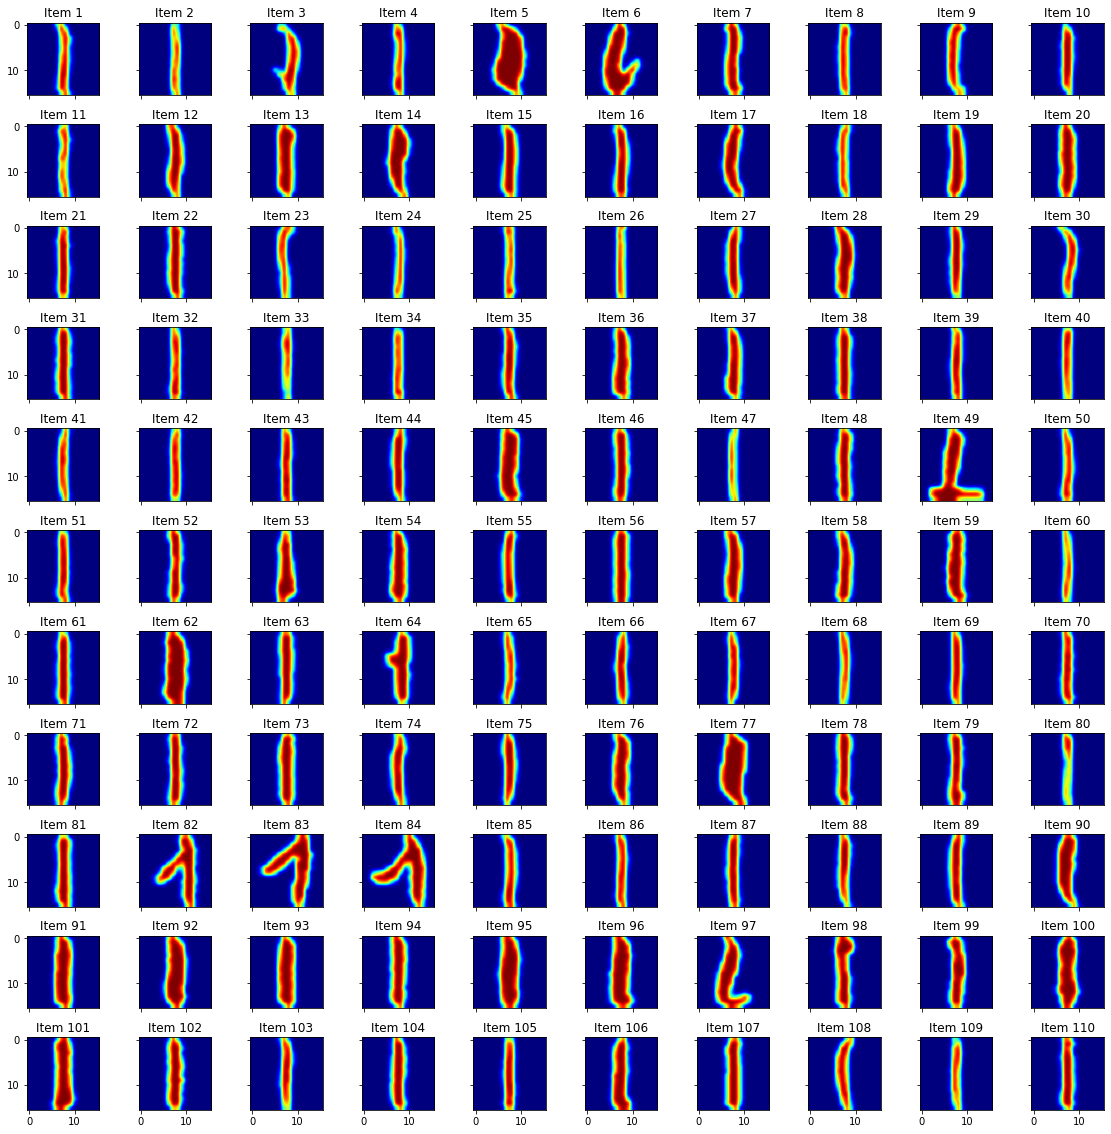

In [41]:
# Plot all 1s

fig = plt.figure(figsize = (20, 20))
gs = fig.add_gridspec(nrows = 11, ncols = 10, 
                      hspace=0.4, wspace=0)

axes = gs.subplots(sharex='col', sharey='row')

for item, ax in enumerate(axes.flatten()): 
    ax.imshow(X_test[:, np.where(y_test == 1)].reshape(dim0_1, 
                                                       dim2_1)[:, item].reshape((16,16)), 
               interpolation='gaussian',
               cmap='jet')
    ax.set_title('Item %d'% (item + 1), fontsize = 12)
    
plt.show()

<span style="font-family:KerkisSans; font-size:1.7em; color: black">Looking at the plots I notice that the quality of the image is excelent and therefore easy for digit 1 to be classified.</span>

<span style="font-family:KerkisSans; font-size:1.7em; color: black">This is rather due to the fact that 1 is a simple figure, with no curves. Someone should try hard in order to write an illegible 1.</span>

# **<span style="font-family:KerkisSans; font-size:1.8em; color: red">Task 3</span>**

I will check the singular values for the different digits. These are the diagonal entries ${\displaystyle \sigma _{i}=\Sigma _{ii}}$ of $ {\displaystyle\mathbf {\Sigma}}$

In [42]:
# Check shapes of the SVDs
for d in range(10):
    print('Digit', d)
    for comp in range(3):        
        print(SVD[d][comp].shape)
    print("------")

Digit 0
(256, 256)
(256,)
(567, 567)
------
Digit 1
(256, 256)
(256,)
(402, 402)
------
Digit 2
(256, 256)
(256,)
(328, 328)
------
Digit 3
(256, 256)
(236,)
(236, 236)
------
Digit 4
(256, 256)
(235,)
(235, 235)
------
Digit 5
(256, 256)
(166,)
(166, 166)
------
Digit 6
(256, 256)
(256,)
(269, 269)
------
Digit 7
(256, 256)
(256,)
(260, 260)
------
Digit 8
(256, 256)
(256,)
(260, 260)
------
Digit 9
(256, 256)
(248,)
(248, 248)
------


## Signular values

### Max singular vales per class

In [43]:
# extract the singular vales per digit
singular_values = {d:{} for d in range(10)}
max_singular_value = {d:{} for d in range(10)}
for d in range(0, 10):
    sing_vals = np.zeros(np.diag(SVD[d][1]).shape[0])
    for pos in range(0, np.diag(SVD[d][1]).shape[0]):    
        sing_vals[pos] = np.diag(SVD[d][1])[pos][pos]
    singular_values[d] = sing_vals
    max_singular_value[d] = sing_vals.max()
singulars = pd.DataFrame(max_singular_value.values(), 
             columns = ['Max singular values'])    
# sort asceding
# check values with lowest score
singulars.sort_values(by='Max singular values', ascending=False)

,Max singular values
1,294.203154
0,241.555333
7,199.430930
9,192.695883
6,187.702719
2,174.640816
8,173.991941
4,169.436389
3,166.467824
5,127.596879


<span style="font-family:KerkisSans; font-size:1.7em; color: black">I notice that digits 0 and 1, that count as the best classifiable digits have the highest singular values, while digit 5 which is the worst classifiable digit has the lowest.</span>

<span style="font-family:KerkisSans; font-size:1.7em; color: black">I will check the distribution of the singular values.</span>

### Plots

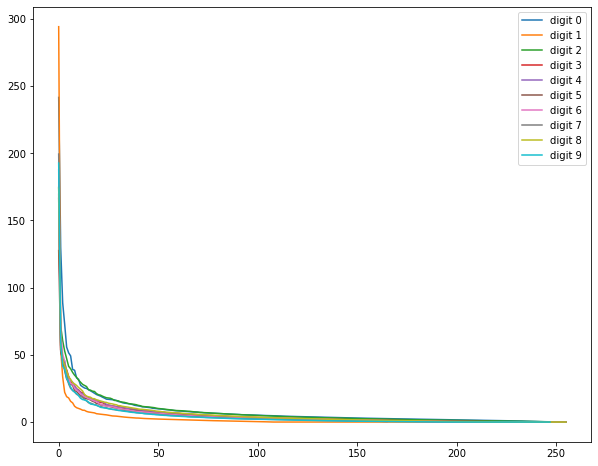

In [44]:
# plot all singular values per digit

fig = plt.figure(figsize = (10,8))

for digit in range(10):
    plt.plot([i for i in range(SVD[digit][1].shape[0])], 
            SVD[digit][1], label = 'digit %d'%digit)
plt.legend()
plt.show()    

<span style="font-family:KerkisSans; font-size:1.7em; color: black">I notice that the distribution follows the Zipf's law, where the bigger values are the few one concentrated between 0 and 50 components.</span>

<span style="font-family:KerkisSans; font-size:1.7em; color: black">Therefore we will plot again the first 40 basis vectors and check graph again.</span>

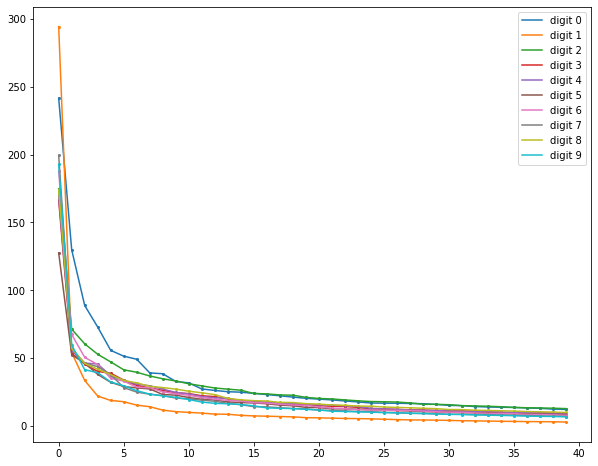

In [45]:
fig = plt.figure(figsize = (10,8))

for digit in range(10):
    plt.scatter([i for i in range(SVD[digit][1][:40].shape[0])], 
            SVD[digit][1][:40], s = 4)
    plt.plot([i for i in range(SVD[digit][1][:40].shape[0])], 
            SVD[digit][1][:40], label = 'digit %d'%digit)
plt.legend()
plt.show()    

<span style="font-family:KerkisSans; font-size:1.7em; color: black">I notice that in most cases the curve drops at around 3 components and becomes almost horizontal around 20 components.</span>

<span style="font-family:KerkisSans; font-size:1.7em; color: black">I plot again the first 10 basis vectors and check graph again.</span>

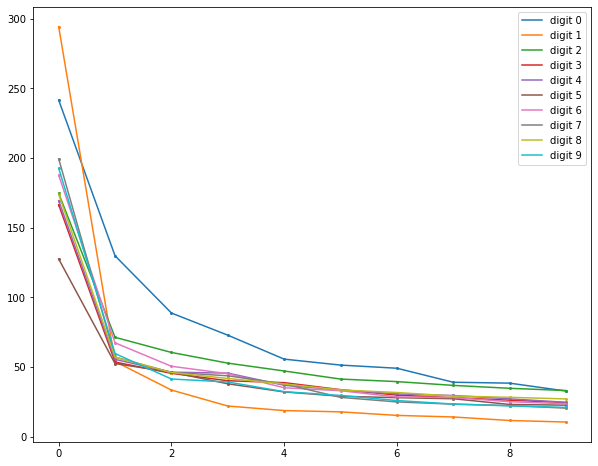

In [46]:
fig = plt.figure(figsize = (10,8))

for digit in range(10):
    plt.scatter([i for i in range(SVD[digit][1][:10].shape[0])], 
            SVD[digit][1][:10], s = 4)
    plt.plot([i for i in range(SVD[digit][1][:10].shape[0])], 
            SVD[digit][1][:10], label = 'digit %d'%digit)
plt.legend()
plt.show()    

<span style="font-family:KerkisSans; font-size:1.7em; color: black">Ι quantify this behaviour by taking only 1 - 15 basis vector of the SVD and counting the residuals.</span>

<span style="font-family:KerkisSans; font-size:1.7em; color: black">I extract the first n columns of the **U** matrix of the calculated SVD. I then calculate the residuals based on the relation $||(I - U_kU_k^T)z ||$ for each digit. 
</span>

## Residuals

In [47]:
# calculate residuals
# n is the number of basis vectors
residuals = {n:{} for n in range(15)}
for n in progressbar.progressbar(range(0, 15)): 
    print("Calculating for %d basis vectors." %n)
        
    res_dig = {d:{} for d in range(10)}
    for d in range(10):
        UUT[d] = SVD[d][0][:, :n] @ SVD[d][0][:, :n].T
        X = X_test[:, np.where(y_test == d)[0]]
        for image in range(X.shape[1]):
            res_dig[d] = np.linalg.norm((np.identity(X.shape[0]) - UUT[d])@X[:, image]) 
   
    residuals[n] =  res_dig 

N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Calculating for 0 basis vectors.


 13% (2 of 15) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:02

Calculating for 1 basis vectors.
Calculating for 2 basis vectors.


 26% (4 of 15) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:02

Calculating for 3 basis vectors.
Calculating for 4 basis vectors.


 40% (6 of 15) |##########               | Elapsed Time: 0:00:01 ETA:   0:00:01

Calculating for 5 basis vectors.
Calculating for 6 basis vectors.


 53% (8 of 15) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01

Calculating for 7 basis vectors.
Calculating for 8 basis vectors.


 60% (9 of 15) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:01

Calculating for 9 basis vectors.


 73% (11 of 15) |#################       | Elapsed Time: 0:00:02 ETA:   0:00:00

Calculating for 10 basis vectors.
Calculating for 11 basis vectors.


 86% (13 of 15) |####################    | Elapsed Time: 0:00:02 ETA:   0:00:00

Calculating for 12 basis vectors.
Calculating for 13 basis vectors.


100% (15 of 15) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Calculating for 14 basis vectors.


### Plot

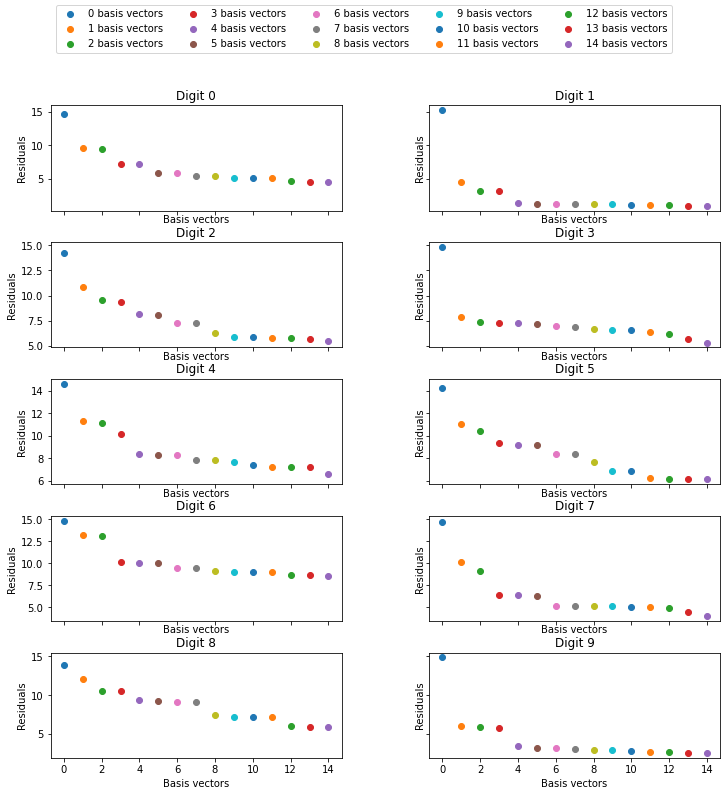

In [48]:
# Plot residuals for each digit and 
# number of basis vectors

fig = plt.figure(figsize = (12, 12))
gs = fig.add_gridspec(nrows = 5, ncols = 2, 
                      hspace=0.3, wspace=0.3)

axes = gs.subplots(sharex='col', sharey='row')
labels = [f"{i} basis vectors" for i in range(15)]
for digit, ax in enumerate(axes.flatten()): 
    for n in range(15):
        ax.scatter(n, residuals[n][digit], 
                label = '%d bn' % (n+1))
        ax.set_title('Digit %d' %digit)
    ax.set_xlabel("Basis vectors")
    ax.set_ylabel("Residuals")
fig.legend(labels=labels, loc="upper center", ncol=5)    
plt.show()

In [49]:
print('Residuals, col: digits, row: basis vectors')
pd.DataFrame(residuals.values())

Residuals, col: digits, row: basis vectors


,0,1,2,3,4,5,6,7,8,9
0,14.614268,15.240179,14.190426,14.818021,14.635076,14.282437,14.847349,14.738287,13.928814,14.853794
1,9.579020,4.459765,10.836507,7.895547,11.288203,11.041033,13.250774,10.108007,12.128783,6.018191
2,9.437465,3.185908,9.604192,7.352325,11.116217,10.391526,13.127189,9.098695,10.594199,5.868412
3,7.198936,3.115900,9.352826,7.256710,10.206284,9.328444,10.170362,6.400011,10.578604,5.750576
4,7.198886,1.393883,8.179168,7.237258,8.405224,9.178933,10.058755,6.375557,9.435594,3.413155
5,5.916823,1.302631,8.091694,7.212134,8.334876,9.156652,9.990679,6.244858,9.227624,3.183356
6,5.891331,1.302438,7.237459,6.965302,8.258772,8.387947,9.488848,5.188548,9.155742,3.150160
7,5.428833,1.259245,7.232314,6.887055,7.821954,8.379527,9.480526,5.188537,9.151236,3.056242
8,5.428828,1.213772,6.282430,6.649834,7.817079,7.708917,9.123631,5.106669,7.417670,2.985929
9,5.192864,1.201586,5.898572,6.598950,7.710936,6.834759,9.030296,5.106495,7.251322,2.904804


<span style="font-family:KerkisSans; font-size:1.7em; color: black">All digits have a high number of residuals when taken 1 to 3 basis vectors. There is a slight differentiation thought, since for example digits 1 drops its residuals down to $< 2$ already after 4 basis components. On the other hand digit 6 remains with a high number of residuals up to the use of 15 basis components. </span>

<span style="font-family:KerkisSans; font-size:1.7em; color: black">Therefore, we could consider variation on the number of basis vectors when modeling the classifiacatoin of handwritten digits.</span>

## Accuracy

<span style="font-family:KerkisSans; font-size:1.7em; color: black">I check how many digits get correctly classified when using only one basis vector. I set a threshold of 70% for the minimum residuals per image and compare. If their ratio is $< 0.7$ then I regard the classification as succesfull, else I proceed using the 10 first basis vectors.</span>

In [50]:
min_residual = []
classify = np.zeros(X_test.shape[1])
success_rate = 0

# for each image in test set
for image in range(X_test.shape[1]):
    # initialize array for residuals
    residual = np.zeros(10)
    # extract image vector
    Image = X_test[:,image]
    # for each digit
    for digit in range(10):
        # calculate the residuals for the first basis vector of U matrix
        # of the svd
        residual[digit] = np.linalg.norm(np.outer(SVD[digit][0][:,:1], 
                                                  SVD[digit][0][:,:1])@Image -\
                                                  Image)
    # extract the minimum residuals per digit 
    one, two = np.sort(residual)[0:2]
    min_residual.append(one/two)
    
    # set a threshold, if the difference between
    # the two minimum residuals is first equal to
    # 70% of the second then
    # classification is successful
    if one <= 0.70 * two:
        classify[image] = np.argmin(residual)
        success_rate +=1
    else:
        for digit in range(10):
            # calculate the residuals for the first 18 basis vectors of U matrix
            # of the svd
            residual[digit] = np.linalg.norm(SVD[digit][0][:,:10]@SVD[digit][0][:,:10].T@Image -\
                                                                                         Image)
        classify[image] = np.argmin(residual)
        
success = confusion_matrix(y_test, classify).trace()/X_test.shape[1]
ratio = success_rate/X_test.shape[1]

In [51]:
print("The accuracy of the classification is calculated at", round(success*100, 3), "%.")
print("\nIn the {} % of the cases the use of one basis vector sufficed \nfor the classification to be accurate.".format(round(ratio*100, 3)))

The accuracy of the classification is calculated at 93.801 %.

In the 22.102 % of the cases the use of one basis vector sufficed 
for the classification to be accurate.


<span style="font-family:KerkisSans; font-size:1.7em; color: black">Concluding, the results is satisfactory when using the same number of basis vectors for all digits.</span>